In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from resnet18k import make_normalized_resnet18k, make_resnet18k, Normalizer

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%autoreload 2

In [3]:
device = torch.device('cuda')
# Load the CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
testset = torchvision.datasets.CIFAR10(root='/fastdata/cifar10', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load the model
model = make_normalized_resnet18k().to(device)
model.load_state_dict(torch.load('resnet18_cifar10_nodp.pt'))
model.eval()

# Get the accuracy of the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the model on the {total} test images: {100 * correct / total} %')

Files already downloaded and verified
Accuracy of the model on the 10000 test images: 88.45 %


# Partial PGD attack on Resnet18 + CIFAR-10

In [4]:

from partialpgd import make_ref_images, pgd_attack, partial_pgd_attack, compute_linf


In [5]:
# Utility function to show an image
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

# Utility function to show multiple images with titles in subplots
def imshow_multi(images, titles, ncols=5):
    nrows = len(images) // ncols + 1
    fig = plt.figure(figsize = (15, 15*(nrows/ncols)))
    for i in range(len(images)):
        ax = fig.add_subplot(len(images) // ncols + 1, ncols, i + 1)
        npimg = images[i].numpy()
        ax.imshow(np.transpose(npimg,(1,2,0)))
        ax.set_title(titles[i])
    plt.show()


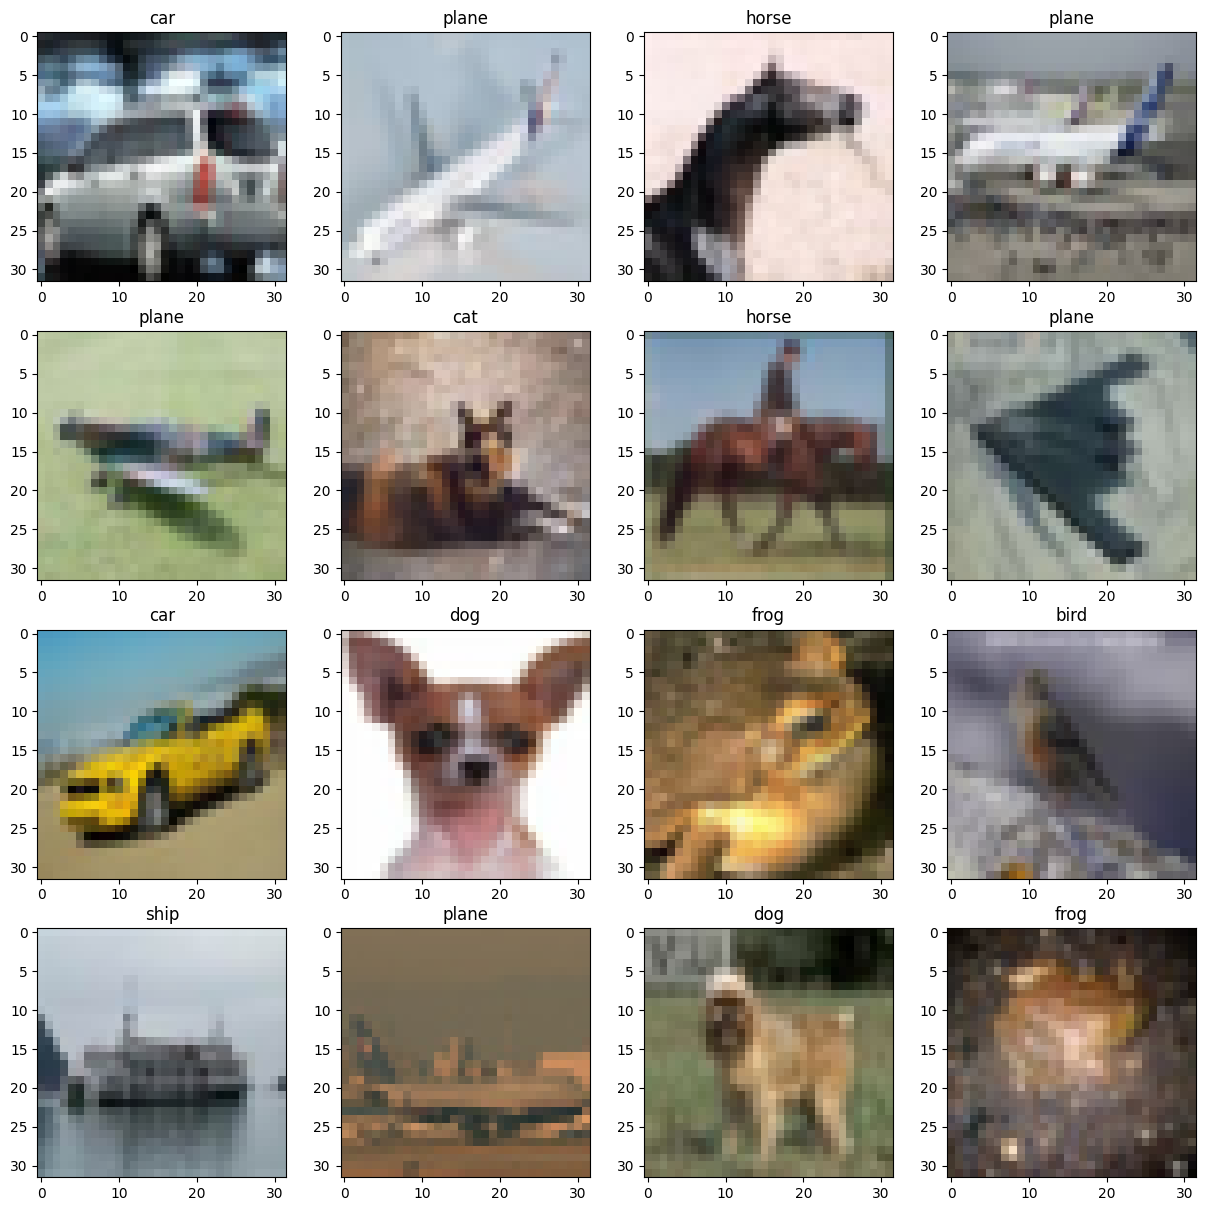

In [6]:
# Get 16 random images from the test set and show them
shufloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True, num_workers=2)
images, labels = next(iter(shufloader))
imshow_multi(images, [cifar10_classes[i] for i in labels], ncols=4)

In [7]:
orig_outputs = model(images.to(device))
_, orig_preds = torch.max(orig_outputs, 1)
orig_preds = orig_preds.cpu()

Iter 0 cost 0.8869629502296448
Iter 1 cost 6.006453037261963
Iter 2 cost 10.046975135803223
Iter 3 cost 11.640768051147461
Iter 4 cost 11.982719421386719
Iter 5 cost 12.183847427368164
Iter 6 cost 12.222612380981445
Iter 7 cost 12.298669815063477
Iter 8 cost 12.28987979888916
Iter 9 cost 12.29376220703125
Iter 10 cost 12.279158592224121
Iter 11 cost 12.209906578063965
Iter 12 cost 12.259603500366211
Iter 13 cost 12.234073638916016
Iter 14 cost 12.252010345458984
Iter 15 cost 12.274001121520996
Iter 16 cost 12.294570922851562
Iter 17 cost 12.310176849365234
Iter 18 cost 12.310150146484375
Iter 19 cost 12.291508674621582
Iter 20 cost 12.283819198608398
Iter 21 cost 12.32502555847168
Iter 22 cost 12.324920654296875
Iter 23 cost 12.314861297607422
Iter 24 cost 12.368196487426758
Iter 25 cost 12.316845893859863
Iter 26 cost 12.326864242553711
Iter 27 cost 12.35928726196289
Iter 28 cost 12.413691520690918
Iter 29 cost 12.344605445861816
Iter 30 cost 12.41191291809082
Iter 31 cost 12.42642593

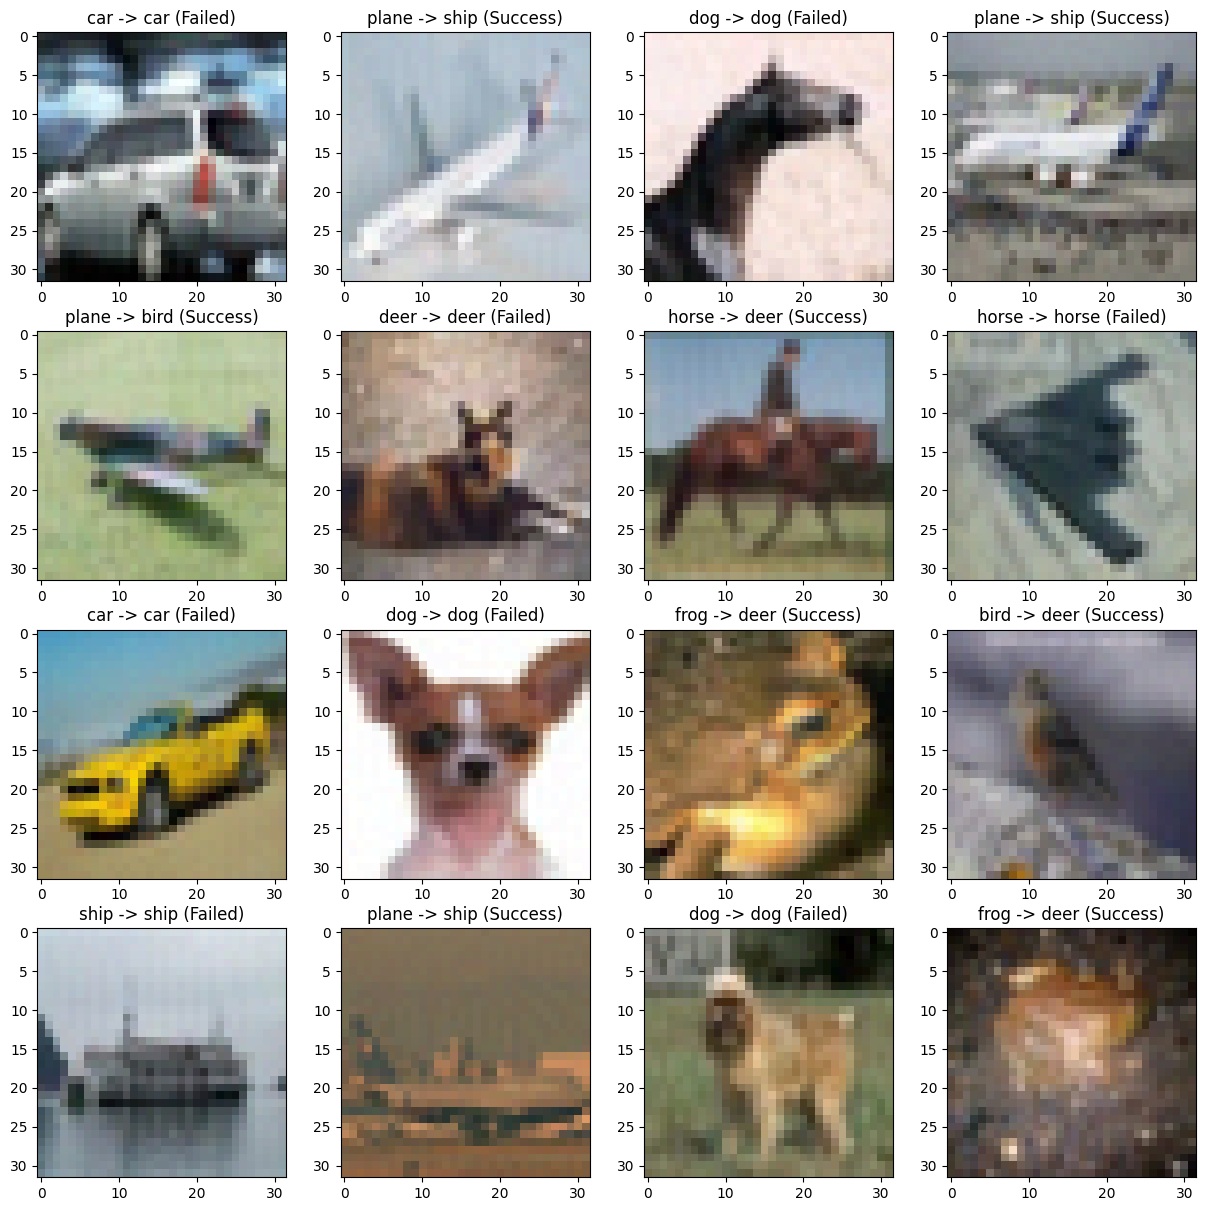

In [8]:
# Run PGD attack
adv_images = pgd_attack(model, images, labels, eps=2/255)

# Get the new predictions
outputs = model(adv_images.to(device))
_, preds = torch.max(outputs, 1)

# Move the images back to the CPU
images = images.cpu()
labels = labels.cpu()
adv_images = adv_images.cpu()
preds = preds.cpu()

success = (preds != orig_preds)
print(f"Success rate: {success.sum().item()/len(orig_preds)}")

# Show the original and adversarial images
imshow_multi(adv_images.cpu(),
             [f'{cifar10_classes[i]} -> {cifar10_classes[j]} ({"Success" if success[idx] else "Failed"})' for idx,(i,j) in enumerate(zip(orig_preds,preds))],
             ncols=4)


In [9]:
# Compute the L_inf norm of the perturbation
print(f"L_inf norm of perturbation: {compute_linf(images, adv_images)}")

L_inf norm of perturbation: 0.007843166589736938


Success rate: 0.6875


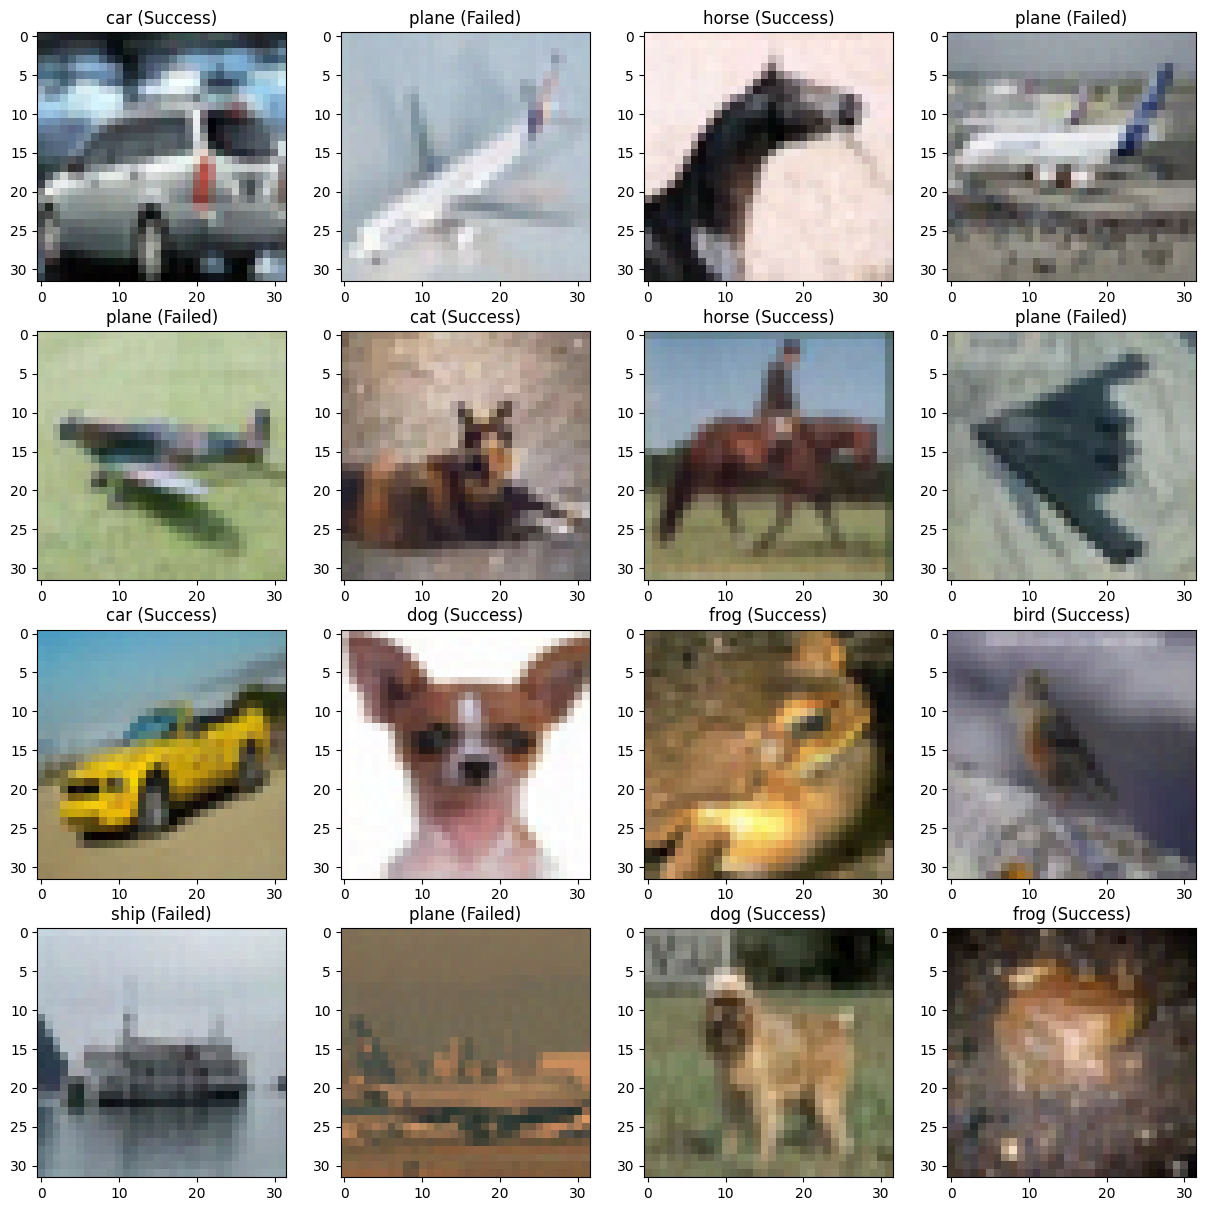

In [10]:
import foolbox as fb
fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.LinfPGD()
images = images.to(device)
labels = labels.to(device)
_, advs, success = attack(fmodel, images, labels, epsilons=2/255)
print(f"Success rate: {success.sum().item()/len(labels)}")
imshow_multi(advs.cpu(), [cifar10_classes[i] + (' (Success)' if success[i] else ' (Failed)') for i in labels], ncols=4)

In [11]:
# Try the partial attack
ref_images = make_ref_images(model, testloader)
adv_images = partial_pgd_attack(model, images, labels, ref_images, layer=model.model.layer2[0].conv1, eps=1/255, alpha=1/255, iters=100)

Batch 0 of 100, 0 ref images found
Target labels:   tensor([9, 3, 1, 5, 4, 4, 6, 2, 8, 1, 3, 3, 9, 8, 6, 5], device='cuda:0')
Original labels: tensor([1, 0, 7, 0, 0, 3, 7, 0, 1, 5, 6, 2, 8, 0, 5, 6], device='cuda:0')
Iter 0 cost -0.20279958844184875
Iter 1 cost -0.19696077704429626
Iter 2 cost -0.1950400322675705
Iter 3 cost -0.1949833780527115
Iter 4 cost -0.19496962428092957
Iter 5 cost -0.1949658840894699
Iter 6 cost -0.19496378302574158
Iter 7 cost -0.1949605643749237
Iter 8 cost -0.19496041536331177
Iter 9 cost -0.19495999813079834
Iter 10 cost -0.1949595808982849
Iter 11 cost -0.1949579268693924
Iter 12 cost -0.1949593424797058
Iter 13 cost -0.1949581503868103
Iter 14 cost -0.19495902955532074
Iter 15 cost -0.19495892524719238
Iter 16 cost -0.19495925307273865
Iter 17 cost -0.19495819509029388
Iter 18 cost -0.19495895504951477
Iter 19 cost -0.19495782256126404
Iter 20 cost -0.19495905935764313
Iter 21 cost -0.19495722651481628
Iter 22 cost -0.19495852291584015
Iter 23 cost -0.194

Success rate: 0.0


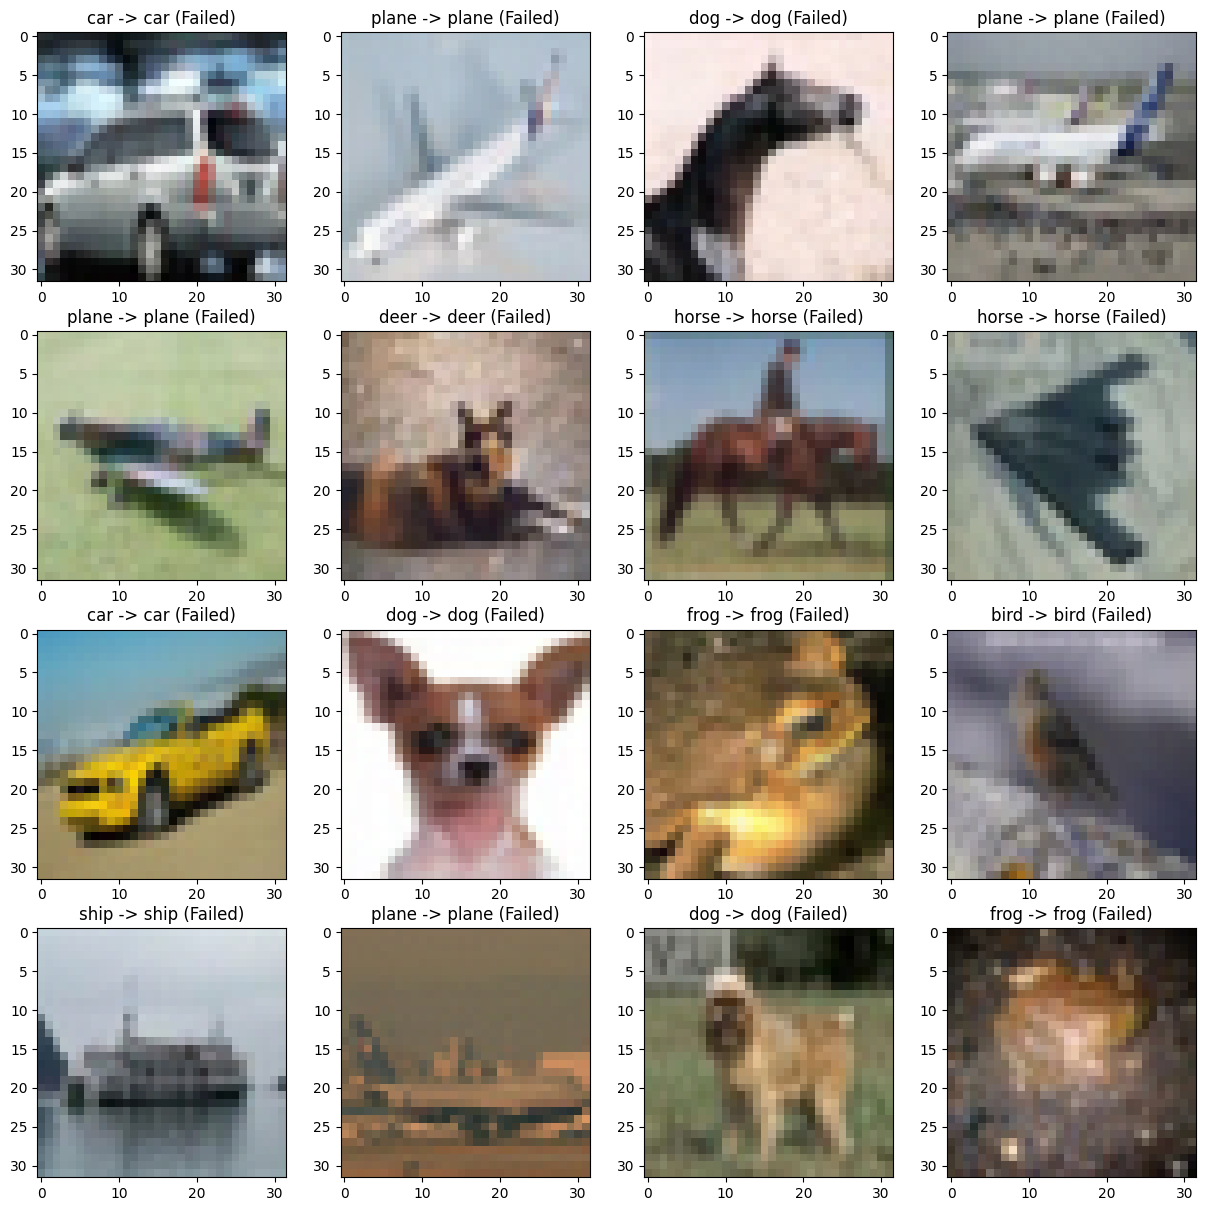

In [12]:
# Get the new predictions
outputs = model(adv_images.to(device))
_, preds = torch.max(outputs, 1)

# Move the images back to the CPU
images = images.cpu()
labels = labels.cpu()
adv_images = adv_images.cpu()
preds = preds.cpu()

success = (preds != orig_preds)
print(f"Success rate: {success.sum().item()/len(orig_preds)}")

# Show the original and adversarial images
imshow_multi(adv_images.cpu(),
             [f'{cifar10_classes[i]} -> {cifar10_classes[j]} ({"Success" if success[idx] else "Failed"})' for idx,(i,j) in enumerate(zip(orig_preds,preds))],
             ncols=4)